In [27]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from vgg_models.vgg import vgg13_bn

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- list of altered datasets -------
altered_datasets = ['cifar10_permuted_block_size_8.pth', 'cifar10_permuted_block_size_16.pth', 'cifar10_fgsa_VGG.pth', 'cifar10_fgsa_MLP.pth']

# ---------- Load the CIFAR-10 test dataset -------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#--------- Load the altered dataset ----------

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = data['image']
        if self.transform:
            image = self.transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary, choose from the altered_datasets list
loaded_dataset = torch.load(altered_datasets[-1])

# Create an instance of the CustomDataset
altered_dataset = CustomDataset(loaded_dataset, transform = transform)
altered_loader = DataLoader(altered_dataset, batch_size=1024, shuffle=False)

# ------------- Load the pretrained model ------------
pretrained_model = vgg13_bn(pretrained=True)
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()


# -----------calculate accuracies -----------

def accuracy_calc(loader, classes, dataset):
    num_classes = len(classes)
    # Initialize a dictionary to store per-class counts
    class_counts = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(num_classes)}

    with torch.no_grad():
        for inputs, labels in loader:

            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update counts for each class
            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_total = class_mask.sum().item()
                class_correct = (predicted[class_mask] == class_idx).sum().item()

                class_counts[class_idx]['correct'] += class_correct
                class_counts[class_idx]['total'] += class_total

    # Calculate per-class accuracy
    per_class_accuracy = {class_idx: class_counts[class_idx]['correct'] / class_counts[class_idx]['total']
                        for class_idx in range(num_classes)}

    # Print per-class accuracy
    total_accuracy = 0
    for class_idx in range(num_classes):
        print(f'{dataset} accuracy for {classes[class_idx]}: {100 * per_class_accuracy[class_idx]:.2f}%') 
        total_accuracy += per_class_accuracy[class_idx]

    print(f'{dataset} total accuracy: {100 * total_accuracy/10:.2f}%')

classes  = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
accuracy_calc(test_loader, classes, 'CIFAR10')
accuracy_calc(altered_loader, classes, 'Permuted CIFAR10')


Files already downloaded and verified
CIFAR10 accuracy for Airplane: 96.00%
CIFAR10 accuracy for Car: 96.80%
CIFAR10 accuracy for Bird: 91.70%
CIFAR10 accuracy for Cat: 87.90%
CIFAR10 accuracy for Deer: 95.50%
CIFAR10 accuracy for Dog: 90.00%
CIFAR10 accuracy for Frog: 95.50%
CIFAR10 accuracy for Horse: 96.10%
CIFAR10 accuracy for Ship: 96.70%
CIFAR10 accuracy for Truck: 95.90%
CIFAR10 total accuracy: 94.21%


/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Permuted CIFAR10 accuracy for Airplane: 67.30%
Permuted CIFAR10 accuracy for Car: 79.20%
Permuted CIFAR10 accuracy for Bird: 67.00%
Permuted CIFAR10 accuracy for Cat: 56.60%
Permuted CIFAR10 accuracy for Deer: 86.80%
Permuted CIFAR10 accuracy for Dog: 61.20%
Permuted CIFAR10 accuracy for Frog: 83.30%
Permuted CIFAR10 accuracy for Horse: 67.40%
Permuted CIFAR10 accuracy for Ship: 87.80%
Permuted CIFAR10 accuracy for Truck: 84.10%
Permuted CIFAR10 total accuracy: 74.07%


Files already downloaded and verified


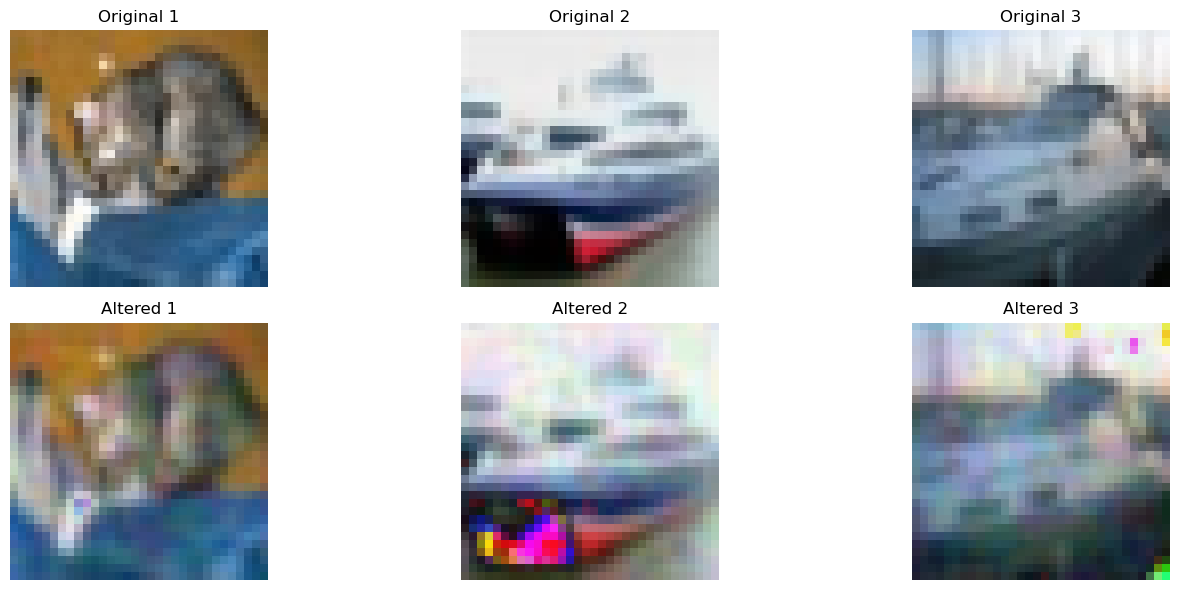

In [30]:
import matplotlib.pyplot as plt
import numpy as np

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
altered_dataset = CustomDataset(loaded_dataset, transform = transforms.Resize(32))

original = test_dataset[0][0]
altered = altered_dataset[0][0]


# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):
    # Original image
    original_image, _ = test_dataset[i]
    axes[0, i].imshow(np.array(original_image))
    axes[0, i].set_title(f'Original {i + 1}')

    # Altered image
    altered_image, _ = altered_dataset[i]
    axes[1, i].imshow(np.array(altered_image))
    axes[1, i].set_title(f'Altered {i + 1}')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()


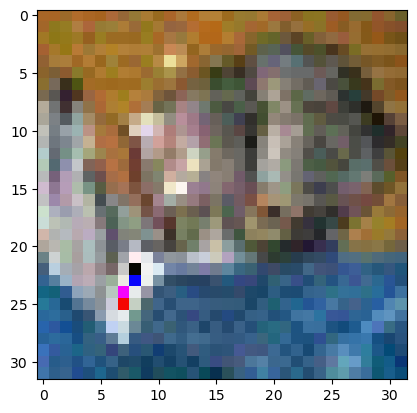

Cat


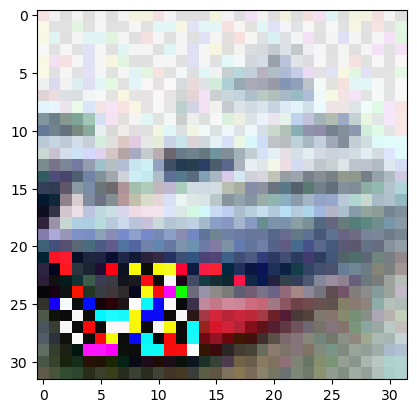

Car


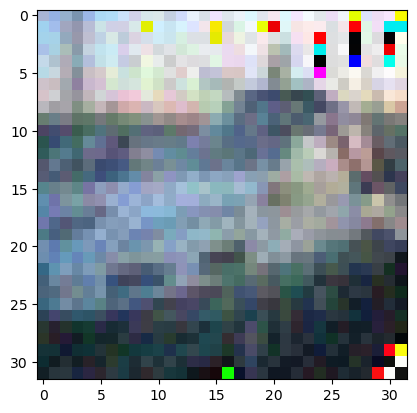

Bird


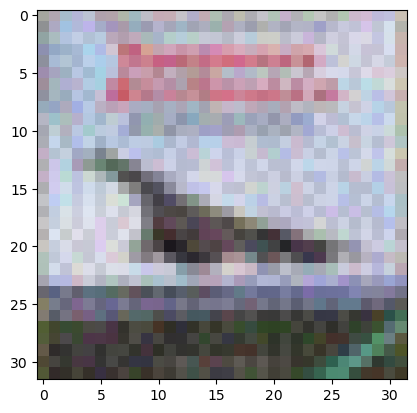

Frog


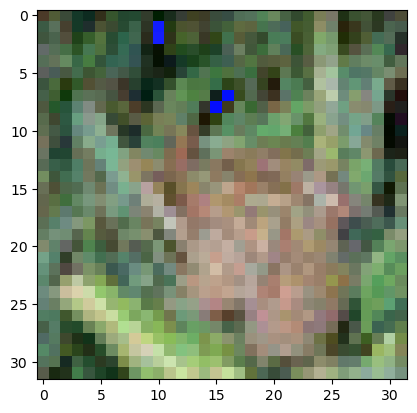

Frog


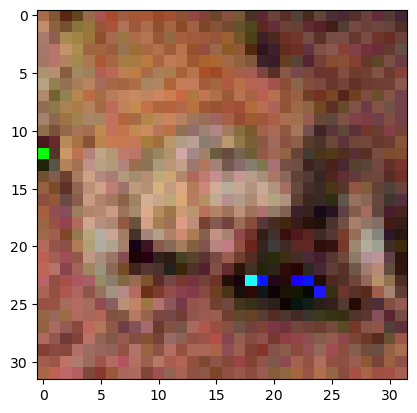

Frog


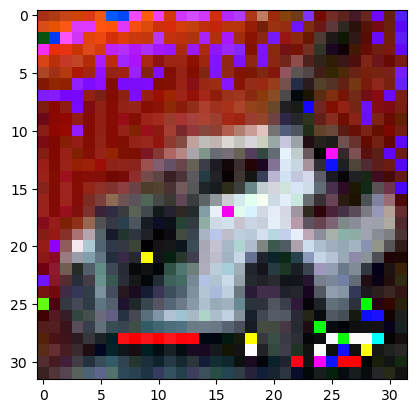

Truck


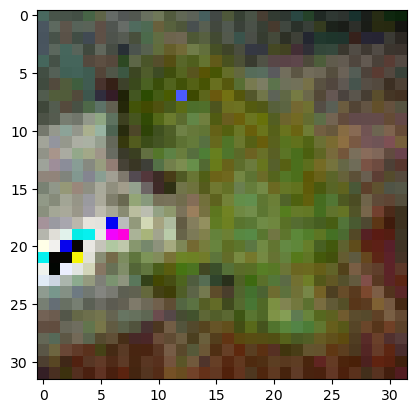

Frog


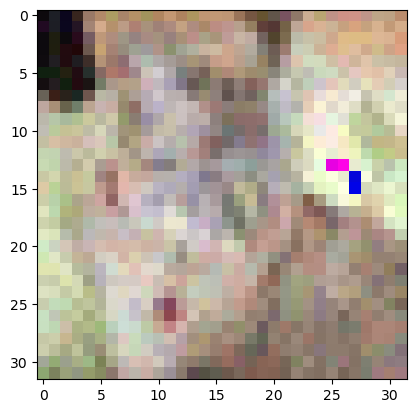

Cat


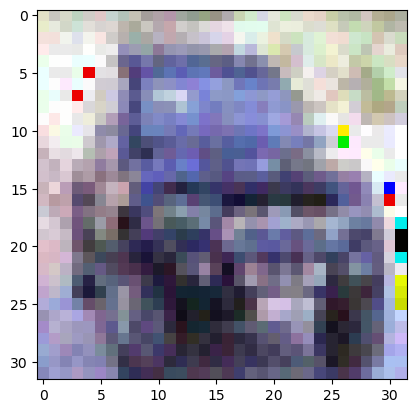

Car


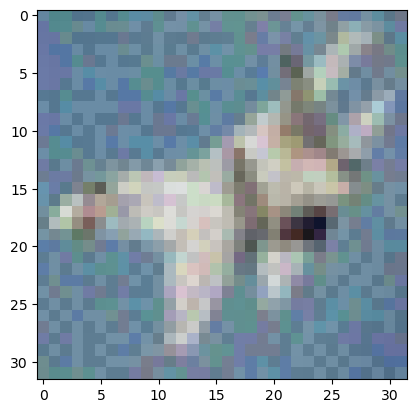

Deer


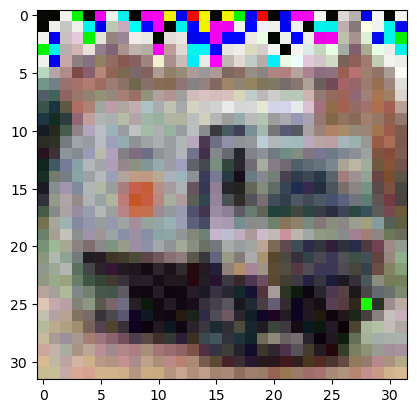

Truck


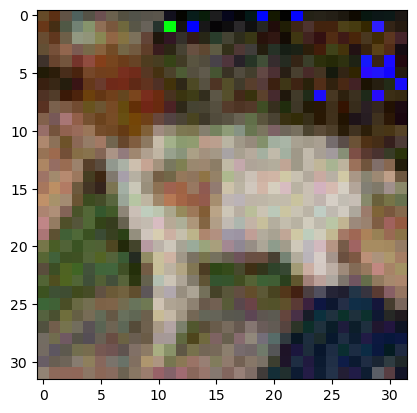

Frog


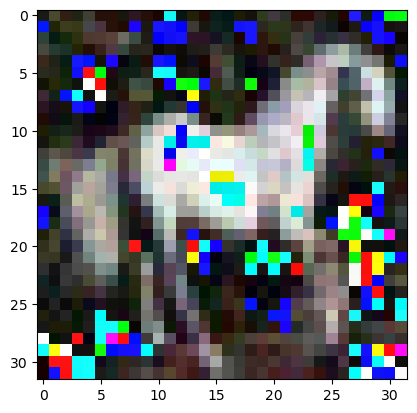

Car


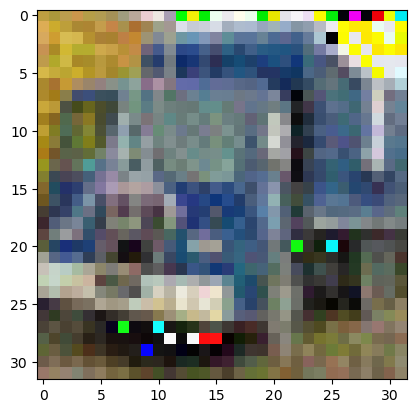

Frog


In [23]:
# Load the dataset dictionary, choose from the altered_datasets list
loaded_dataset = torch.load(altered_datasets[-1])

# Create an instance of the CustomDataset
altered_dataset = CustomDataset(loaded_dataset, transform = None)

for i in range(15):
    plt.imshow(np.array(altered_dataset[i][0]))
    plt.show()
    print(classes[torch.argmax(pretrained_model(transform(altered_dataset[i][0]).unsqueeze(0)), -1)])

